<a href="https://colab.research.google.com/github/leonmck-dsp-dev/nueraspeech/blob/main/nueraspeech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

In [2]:
# Uncomment the line corresponding to your "runtime type" to run in Google Colab

# CPU:
# !pip install pydub torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# GPU:
# !pip install pydub torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys
from torchaudio import transforms
import matplotlib.pyplot as plt
import IPython.display as ipd
import editdistance

from tqdm import tqdm

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


train_set = SubsetSC("training")
test_set = SubsetSC("testing")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

100%|██████████| 2.26G/2.26G [00:13<00:00, 180MB/s]


Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


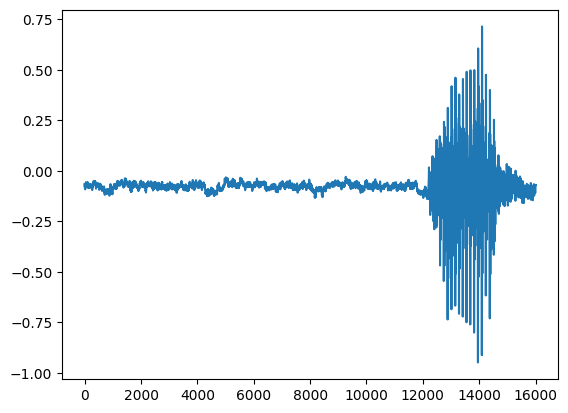

In [5]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

In [6]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels

['backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero']

In [7]:
waveform_first, *_ = train_set[0]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)

waveform_second, *_ = train_set[1]
ipd.Audio(waveform_second.numpy(), rate=sample_rate)

The last file is someone saying “visual”.




In [8]:
waveform_last, *_ = train_set[-1]
ipd.Audio(waveform_last.numpy(), rate=sample_rate)

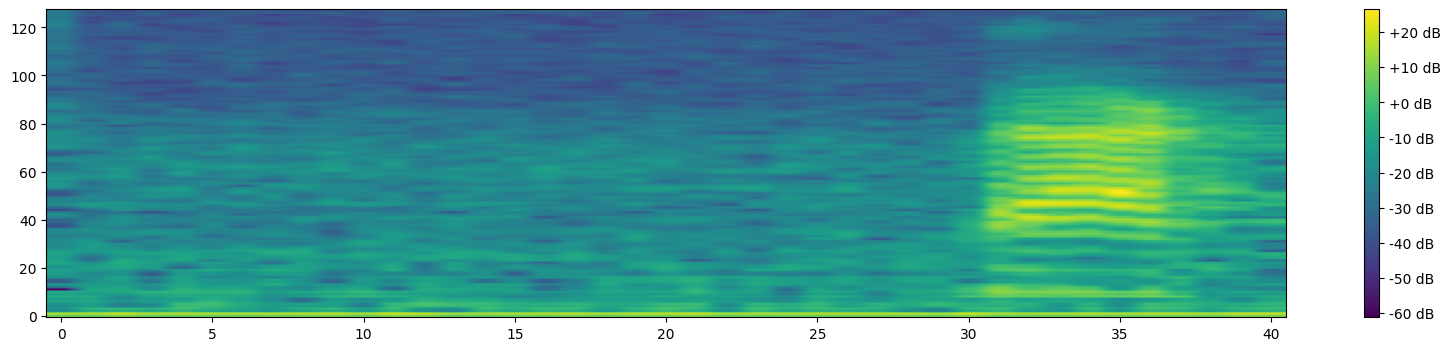

In [9]:
new_sample_rate = 8000
import torchaudio
import random
import numpy as np

class SpecAugment:
    def __init__(self, freq_mask_param, time_mask_param, num_time_masks=1, num_freq_masks=1):
        self.freq_mask_param = freq_mask_param
        self.time_mask_param = time_mask_param
        self.num_time_masks = num_time_masks
        self.num_freq_masks = num_freq_masks

    def __call__(self, specs):
        augmented_specs = []
        for spec in specs:
            # Frequency Masking
            for _ in range(self.num_freq_masks):
                num_freqs, num_frames = spec.shape
                f = random.randrange(0, self.freq_mask_param)
                f0 = random.randrange(0, num_freqs - f)
                spec[f0:f0 + f, :] = 0

            # Time Masking
            for _ in range(self.num_time_masks):
                num_freqs, num_frames = spec.shape
                t = random.randrange(0, self.time_mask_param)
                t0 = random.randrange(0, num_frames - t)
                spec[:, t0:t0 + t] = 0

            augmented_specs.append(spec)

        return torch.stack(augmented_specs)


# 1. Resample
resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
resampled_waveform = resampler(waveform)

# 2. Convert to Mel-spectrogram
mel_transform = torchaudio.transforms.MelSpectrogram(sample_rate=new_sample_rate, n_mels=128)
mel_spectrogram = mel_transform(resampled_waveform)

# 3. Convert to dB scale
db_transform = torchaudio.transforms.AmplitudeToDB()
db_mel_spectrogram = db_transform(mel_spectrogram)

mel_spectrogram_transform = torch.nn.Sequential(
    torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate),
    torchaudio.transforms.MelSpectrogram(sample_rate=new_sample_rate, n_mels=128),
    torchaudio.transforms.AmplitudeToDB()
)

# Instantiate and apply
spec_augment = SpecAugment(freq_mask_param=30, time_mask_param=30)

# Display
plt.figure(figsize=(20, 4))
plt.imshow(db_mel_spectrogram[0].detach().numpy(), cmap='viridis', origin='lower', aspect='auto')
plt.colorbar(format="%+2.0f dB")
plt.show()

print("Shape of the Mel spectrogram:", mel_spectrogram.shape)
# Listen to the resampled audio
ipd.Audio(resampled_waveform.numpy(), rate=new_sample_rate)


In [11]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))

def index_to_label(tensor):
    # Convert tensor of indices into its string labels
    if tensor.dim() == 0:  # If tensor is a scalar
        return labels[tensor.item()]
    else:  # If tensor is not a scalar
        return [labels[index] for index in tensor.cpu().numpy()]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(33) --> yes


In [22]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 32
if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

In [ ]:
print(torch.__version__)

# Nueraspeech model architecture
## Acoustic Model (Convolutional Layers)

### Convolutional Neural Networks (CNNs)
A convolutional layer employs a set of learnable filters, which are used to spatially convolve with the input data to produce feature maps. Mathematically, for a 1D input $x$ and a filter $h$, convolution is represented as:

$$
y(t) = (x * h)(t) = \sum_{a=-\infty}^{\infty} x(a)h(t-a)
$$

### Batch Normalization

Batch normalization normalizes the output of a previous activation layer by subtracting the batch mean and dividing by the batch standard deviation.

$$
\hat{x} = \frac{x - \text{E}[x]}{\sqrt{\text{Var}[x]+\epsilon}}
$$

Where:
- $\hat{x}$ is the normalized data.
- $\text{E}[x]$ is the mean of the batch data.
- $\text{Var}[x]$ is the variance of the batch data.
- $\epsilon$ is a small constant to avoid division by zero.

---

## Recurrent Layers (GRU Layers)

### Gated Recurrent Units (GRUs)

GRUs are a type of recurrent neural network (RNN) architecture. The GRU uses gating mechanisms (reset gate and update gate) to control the flow of information.

$$
r_t = \sigma(W_r x_t + U_r h_{t-1} + b_r)
$$
$$
z_t = \sigma(W_z x_t + U_z h_{t-1} + b_z)
$$
$$
\tilde{h}_t = \tanh(W x_t + r_t \odot (U h_{t-1} + b) + b')
$$
$$
h_t = (1 - z_t) \odot h_{t-1} + z_t \odot \tilde{h}_t
$$

Where:
- $r_t$ is the reset gate.
- $z_t$ is the update gate.
- $\tilde{h}_t$ is the candidate activation.
- $h_t$ is the output.
- $\sigma$ is the sigmoid function.
- $\odot$ is the element-wise multiplication.

---

## Transformer Attention

### Self Attention

The self-attention mechanism allows the model to weigh the significance of each part in a sequence based on its content. For a query $Q$, key $K$, and value $V$ set, the attention mechanism is defined as:

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right) V
$$

Where $d_k$ is the dimension of the keys.

### Multi-head Attention

Instead of using one set of attention weights, multi-head attention uses multiple sets, allowing the model to focus on different parts of the input for different tasks or reasons.

---

## Residual Connections (ResBlocks)

Residual connections (or skip connections) allow for the direct flow of gradients during the backpropagation process. If $x$ is the input and $F(x)$ is the output after some layers, the residual connection is:

$$
\text{output} = x + F(x)
$$

This ensures that even as $F(x)$ learns the residuals (or errors), the original input is preserved.


In [26]:

# Define the model architecture
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)

        # This is the skip connection:
        self.skip = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.skip(x)
        return F.relu(out)# Correcting the indentation and redefining AcousticModel

class AcousticModel(nn.Module):
    def __init__(self, n_input, n_channel):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2)  # Reduced stride
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(2)  # Reduced stride
        self.resblock1 = ResBlock(n_channel, n_channel)
        self.resblock2 = ResBlock(n_channel, n_channel)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.resblock1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.resblock2(x)
        return x



class RecurrentLayers(nn.Module):
    def __init__(self, n_channel, hidden_dim, num_layers):
        super().__init__()
        self.gru = nn.GRU(n_channel, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.gru2 = nn.GRU(hidden_dim*2, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.gru3 = nn.GRU(hidden_dim*2, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True)

    def forward(self, x):
        x, _ = self.gru(x)
        x, _ = self.gru2(x)
        x, _ = self.gru3(x)
        return x

class TransformerAttention(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, dropout, num_layers):
        super().__init__()
        self.transformer_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer = nn.TransformerEncoder(self.transformer_layer, num_layers=num_layers)
        self.attention = nn.MultiheadAttention(embed_dim=d_model, num_heads=nhead, dropout=dropout)
        self.relu3 = nn.ReLU()

    def forward(self, x):
        x = self.transformer(x)
        x, _ = self.attention(x, x, x)
        return self.relu3(x)

class nueraspeechASR(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32, hidden_dim=128, num_layers=1, d_model=256, nhead=4, dim_feedforward=256, dropout=0.1):
        super().__init__()
        self.acoustic_model = AcousticModel(n_input, n_channel)
        self.recurrent_layers = RecurrentLayers(n_channel, hidden_dim, num_layers)
        self.transformer_attention = TransformerAttention(d_model, nhead, dim_feedforward, dropout, num_layers)
        self.fc1 = nn.Linear(hidden_dim*2, n_output)
        self.relu4 = nn.ReLU()

    def forward(self, x):
        x = self.acoustic_model(x)
        x = x.permute(0, 2, 1)
        x = self.recurrent_layers(x)
        x = self.transformer_attention(x)
        x = x[:, -1, :]
        x = self.fc1(x)
        x = self.relu4(x)
        return F.log_softmax(x, dim=1)

# Testing the model
n_input = 128  # Number of Mel channels
n_output = 35  # Number of classes/labels

# Initialize the model
model = nueraspeechASR(n_input=n_input, n_output=n_output)
print(model)

# Print number of parameters
print(f'The model has {sum(p.numel() for p in model.parameters()):,} trainable parameters')

# Adjust the shape of the input tensor for testing purposes
x = torch.randn(1, 128, 8000)  # [batch_size, n_mels, time]
OUT = model(x)
print(OUT.shape)


nueraspeechASR(
  (acoustic_model): AcousticModel(
    (conv1): Conv1d(128, 32, kernel_size=(5,), stride=(2,))
    (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
    (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
    (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (resblock1): ResBlock(
      (conv1): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential()
    )
    (resbloc

In [29]:
# @title Default title text

n_epoch = 10
# Hyperparameters
lr = 1e-4
weight_decay = 0.001
dropout_rate = 0.3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                            steps_per_epoch=int(len(train_loader)),
                                            epochs=n_epoch,
                                            anneal_strategy='linear')


pbar = tqdm(total=len(train_loader.dataset), desc="Training Progress")
PATH = "nueraspeech.pth"


Training Progress:   0%|          | 0.5353805073431296/84843 [03:42<9780:12:14, 414.99s/it]


In [15]:
def train(model, epoch, log_interval):
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.squeeze(1)  # This will remove the single channel dimension, turning [batch_size, 1, 128, 41] into [batch_size, 128, 41]

        # Preprocess the data with Mel-spectrogram transform
        data = mel_spectrogram_transform(data)

        # Apply SpecAugment (only during training)
        data = spec_augment(data)
        data = data.to(device)


        target = target.to(device)

        output = model(data)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())


In [16]:
def wer(s1, s2):
    """
    Compute the Word Error Rate between two lists of words.
    """
    b = set(s1 + s2)
    word2char = dict(zip(b, range(len(b))))

    w1 = [chr(word2char[w]) for w in s1]
    w2 = [chr(word2char[w]) for w in s2]

    return editdistance.eval(" ".join(w1), " ".join(w2)) / len(s2)
def cer(s1, s2):
    """
    Compute the Character Error Rate between two lists of words.
    """
    s1 = " ".join(s1)
    s2 = " ".join(s2)

    return editdistance.eval(s1, s2) / len(s2)


def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)
wer_over_epochs = []
cer_over_epochs = []
correct_predictions_over_epochs = []

def test(model, epoch):
    model.eval()
    correct = 0
    total_wer, total_cer, total_samples = 0, 0, 0

    for data, target in test_loader:
        # Apply Mel-spectrogram transform
        data = mel_spectrogram_transform(data)

        # Remove channel dimension after applying mel transform
        data = data.squeeze(1)  # This will convert [batch_size, 1, 128, 41] into [batch_size, 128, 41]

        data = data.to(device)
        target = target.to(device)

        output = model(data)
        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # Compute WER and CER
        pred_str = index_to_label(pred)  # Convert the prediction indices to string
        target_str = index_to_label(target)  # Convert target indices to string

        total_wer += wer(pred_str, target_str)
        total_cer += cer(pred_str, target_str)
        total_samples += 1

        # update progress bar
        pbar.update(pbar_update)

    avg_wer = total_wer / total_samples
    avg_cer = total_cer / total_samples

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)")
    print(f"Average WER: {avg_wer:.4f}\nAverage CER: {avg_cer:.4f}\n")

    return avg_wer, avg_cer, correct

In [ ]:
log_interval = 20
pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []
model = model.to(device)


for epoch in range(1, n_epoch + 1):
    train(model, epoch, log_interval)
    # Evaluate the model
    avg_wer, avg_cer, correct_predictions = test(model, epoch)

    # Store the metrics for plotting or further analysis
    wer_over_epochs.append(avg_wer)
    cer_over_epochs.append(avg_cer)
    correct_predictions_over_epochs.append(correct_predictions)
    scheduler.step()
   # Save
    torch.save(model.state_dict(), PATH)
    print("saved")
# Let's plot the training loss versus the number of iteration.
# plt.plot(losses);
# plt.title("training loss");


Training Progress:   0%|          | 0.0003337783711615487/84843 [00:10<770840:44:15, 32707.79s/it]
Training Progress:   0%|          | 0.0016688918558077437/84843 [00:11<116584:01:36, 4946.81s/it] 

Train Epoch: 1 [0/84843 (0%)]	Loss: 3.553483



Training Progress:   0%|          | 0.003004005340453939/84843 [00:11<53714:33:25, 2279.18s/it]  
Training Progress:   0%|          | 0.0043391188251001335/84843 [00:11<31005:31:54, 1315.61s/it]
Training Progress:   0%|          | 0.005674232309746327/84843 [00:11<19845:35:57, 842.07s/it]  
Training Progress:   0%|          | 0.007009345794392521/84843 [00:11<13478:53:36, 571.93s/it]
Training Progress:   0%|          | 0.008344459279038716/84843 [00:11<9595:54:02, 407.17s/it] 

Train Epoch: 1 [640/84843 (1%)]	Loss: 3.535212



Training Progress:   0%|          | 0.009679572763684913/84843 [00:11<7104:23:36, 301.45s/it]
Training Progress:   0%|          | 0.01101468624833111/84843 [00:11<5473:35:39, 232.25s/it] 
Training Progress:   0%|          | 0.012349799732977307/84843 [00:11<4380:32:44, 185.87s/it]
Training Progress:   0%|          | 0.013684913217623504/84843 [00:12<3621:55:52, 153.68s/it]
Training Progress:   0%|          | 0.015020026702269701/84843 [00:12<3095:16:38, 131.34s/it]

Train Epoch: 1 [1280/84843 (2%)]	Loss: 3.491118



Training Progress:   0%|          | 0.016355140186915897/84843 [00:12<2740:58:05, 116.30s/it]
Training Progress:   0%|          | 0.017690253671562094/84843 [00:12<2481:04:42, 105.28s/it]
Training Progress:   0%|          | 0.01902536715620829/84843 [00:12<2365:02:55, 100.35s/it] 
Training Progress:   0%|          | 0.020360480640854488/84843 [00:12<2214:20:00, 93.96s/it]
Training Progress:   0%|          | 0.021695594125500685/84843 [00:12<2137:07:20, 90.68s/it]

Train Epoch: 1 [1920/84843 (2%)]	Loss: 3.538867



Training Progress:   0%|          | 0.023030707610146882/84843 [00:12<2137:22:24, 90.69s/it]
Training Progress:   0%|          | 0.02436582109479308/84843 [00:12<2193:53:24, 93.09s/it] 
Training Progress:   0%|          | 0.025700934579439276/84843 [00:13<2332:12:32, 98.96s/it]
Training Progress:   0%|          | 0.027036048064085473/84843 [00:13<2910:15:04, 123.49s/it]
Training Progress:   0%|          | 0.02803738317757012/84843 [00:13<2966:22:32, 125.87s/it] 

Train Epoch: 1 [2560/84843 (3%)]	Loss: 3.491628



Training Progress:   0%|          | 0.02903871829105477/84843 [00:13<2869:01:12, 121.74s/it]
Training Progress:   0%|          | 0.030040053404539416/84843 [00:13<3370:44:42, 143.03s/it]
Training Progress:   0%|          | 0.031041388518024064/84843 [00:13<3159:10:38, 134.05s/it]
Training Progress:   0%|          | 0.0320427236315087/84843 [00:14<2946:16:27, 125.01s/it]  
Training Progress:   0%|          | 0.03304405874499334/84843 [00:14<2793:20:39, 118.53s/it]
Training Progress:   0%|          | 0.034045393858477976/84843 [00:14<2697:45:57, 114.47s/it]
Training Progress:   0%|          | 0.035046728971962614/84843 [00:14<2624:52:02, 111.38s/it]

Train Epoch: 1 [3200/84843 (4%)]	Loss: 3.455869



Training Progress:   0%|          | 0.03604806408544725/84843 [00:14<2611:53:19, 110.83s/it] 
Training Progress:   0%|          | 0.03704939919893189/84843 [00:14<2565:42:15, 108.87s/it]
Training Progress:   0%|          | 0.038050734312416526/84843 [00:14<2540:43:24, 107.81s/it]
Training Progress:   0%|          | 0.03905206942590116/84843 [00:14<2500:25:13, 106.10s/it] 
Training Progress:   0%|          | 0.0400534045393858/84843 [00:14<2505:28:00, 106.31s/it] 
Training Progress:   0%|          | 0.04105473965287044/84843 [00:14<2465:46:05, 104.63s/it]
Training Progress:   0%|          | 0.042056074766355075/84843 [00:15<2499:40:07, 106.06s/it]

Train Epoch: 1 [3840/84843 (5%)]	Loss: 3.530215



Training Progress:   0%|          | 0.04305740987983971/84843 [00:15<2515:28:08, 106.73s/it] 
Training Progress:   0%|          | 0.044392523364485896/84843 [00:15<2388:15:11, 101.34s/it]
Training Progress:   0%|          | 0.04572763684913208/84843 [00:15<2232:41:13, 94.74s/it]  
Training Progress:   0%|          | 0.04706275033377826/84843 [00:15<2160:13:41, 91.66s/it]
Training Progress:   0%|          | 0.048397863818424446/84843 [00:15<2136:21:24, 90.65s/it]

Train Epoch: 1 [4480/84843 (5%)]	Loss: 3.528363



Training Progress:   0%|          | 0.04973297730307063/84843 [00:15<2068:32:56, 87.77s/it] 
Training Progress:   0%|          | 0.05106809078771681/84843 [00:15<2026:34:54, 85.99s/it]
Training Progress:   0%|          | 0.052403204272362995/84843 [00:15<2007:22:01, 85.18s/it]
Training Progress:   0%|          | 0.05373831775700918/84843 [00:16<2013:22:03, 85.43s/it] 
Training Progress:   0%|          | 0.05507343124165536/84843 [00:16<2005:22:40, 85.09s/it]

Train Epoch: 1 [5120/84843 (6%)]	Loss: 3.546794



Training Progress:   0%|          | 0.056408544726301545/84843 [00:16<2002:22:19, 84.96s/it]
Training Progress:   0%|          | 0.05774365821094773/84843 [00:16<1973:58:29, 83.76s/it] 
Training Progress:   0%|          | 0.05907877169559391/84843 [00:16<1947:29:47, 82.63s/it]
Training Progress:   0%|          | 0.060413885180240094/84843 [00:16<1936:05:13, 82.15s/it]
Training Progress:   0%|          | 0.06174899866488628/84843 [00:16<1923:41:57, 81.63s/it] 

Train Epoch: 1 [5760/84843 (7%)]	Loss: 3.485296



Training Progress:   0%|          | 0.06308411214953247/84843 [00:16<2009:22:25, 85.26s/it]
Training Progress:   0%|          | 0.06441922563417868/84843 [00:16<1995:23:18, 84.67s/it]
Training Progress:   0%|          | 0.06575433911882489/84843 [00:17<1998:00:56, 84.78s/it]
Training Progress:   0%|          | 0.0670894526034711/84843 [00:17<2044:02:06, 86.73s/it] 
Training Progress:   0%|          | 0.06842456608811731/84843 [00:17<2026:26:03, 85.98s/it]

Train Epoch: 1 [6400/84843 (8%)]	Loss: 3.524844



Training Progress:   0%|          | 0.06975967957276352/84843 [00:17<2007:28:48, 85.18s/it]
Training Progress:   0%|          | 0.07109479305740973/84843 [00:17<2003:30:01, 85.01s/it]
Training Progress:   0%|          | 0.07242990654205594/84843 [00:17<1981:57:59, 84.10s/it]
Training Progress:   0%|          | 0.07376502002670215/84843 [00:17<2001:53:17, 84.94s/it]
Training Progress:   0%|          | 0.07510013351134837/84843 [00:17<2016:07:10, 85.55s/it]

Train Epoch: 1 [7040/84843 (8%)]	Loss: 3.539536



Training Progress:   0%|          | 0.07643524699599458/84843 [00:17<1979:47:59, 84.01s/it]
Training Progress:   0%|          | 0.07777036048064079/84843 [00:18<1963:42:39, 83.32s/it]
Training Progress:   0%|          | 0.079105473965287/84843 [00:18<2021:19:47, 85.77s/it]  
Training Progress:   0%|          | 0.08044058744993321/84843 [00:18<2002:00:28, 84.95s/it]
Training Progress:   0%|          | 0.08177570093457942/84843 [00:18<1975:11:47, 83.81s/it]

Train Epoch: 1 [7680/84843 (9%)]	Loss: 3.465881



Training Progress:   0%|          | 0.08311081441922563/84843 [00:18<2030:30:37, 86.16s/it]
Training Progress:   0%|          | 0.08444592790387184/84843 [00:18<2006:43:11, 85.15s/it]
Training Progress:   0%|          | 0.08578104138851805/84843 [00:18<1989:17:00, 84.41s/it]
Training Progress:   0%|          | 0.08711615487316426/84843 [00:18<1976:30:45, 83.87s/it]
Training Progress:   0%|          | 0.08845126835781048/84843 [00:19<1984:10:32, 84.19s/it]

Train Epoch: 1 [8320/84843 (10%)]	Loss: 3.540131



Training Progress:   0%|          | 0.08978638184245669/84843 [00:19<2026:42:54, 86.00s/it]
Training Progress:   0%|          | 0.0911214953271029/84843 [00:19<1983:49:26, 84.18s/it] 
Training Progress:   0%|          | 0.09245660881174911/84843 [00:19<1955:50:30, 82.99s/it]
Training Progress:   0%|          | 0.09379172229639532/84843 [00:19<1953:15:17, 82.88s/it]
Training Progress:   0%|          | 0.09512683578104153/84843 [00:19<1958:29:25, 83.10s/it]

Train Epoch: 1 [8960/84843 (11%)]	Loss: 3.575473



Training Progress:   0%|          | 0.09646194926568774/84843 [00:19<1974:58:27, 83.80s/it]
Training Progress:   0%|          | 0.09779706275033395/84843 [00:19<1955:18:39, 82.97s/it]
Training Progress:   0%|          | 0.09913217623498016/84843 [00:19<1942:16:52, 82.41s/it]
Training Progress:   0%|          | 0.10046728971962637/84843 [00:19<1919:25:30, 81.44s/it]
Training Progress:   0%|          | 0.10180240320427258/84843 [00:20<2012:54:03, 85.41s/it]

Train Epoch: 1 [9600/84843 (11%)]	Loss: 3.528942



Training Progress:   0%|          | 0.1031375166889188/84843 [00:20<2011:31:16, 85.35s/it] 
Training Progress:   0%|          | 0.104472630173565/84843 [00:20<2010:35:17, 85.31s/it] 
Training Progress:   0%|          | 0.10580774365821122/84843 [00:20<1964:54:42, 83.37s/it]
Training Progress:   0%|          | 0.10714285714285743/84843 [00:20<1950:48:17, 82.78s/it]
Training Progress:   0%|          | 0.10847797062750364/84843 [00:20<1921:59:15, 81.55s/it]

Train Epoch: 1 [10240/84843 (12%)]	Loss: 3.517655



Training Progress:   0%|          | 0.10981308411214985/84843 [00:20<1930:34:05, 81.92s/it]
Training Progress:   0%|          | 0.11114819759679606/84843 [00:20<1913:49:22, 81.21s/it]
Training Progress:   0%|          | 0.11248331108144227/84843 [00:20<1914:25:58, 81.23s/it]
Training Progress:   0%|          | 0.11381842456608848/84843 [00:21<1932:56:00, 82.02s/it]
Training Progress:   0%|          | 0.1151535380507347/84843 [00:21<1901:16:42, 80.67s/it] 

Train Epoch: 1 [10880/84843 (13%)]	Loss: 3.597398



Training Progress:   0%|          | 0.1164886515353809/84843 [00:21<1972:09:41, 83.68s/it]
Training Progress:   0%|          | 0.11782376502002712/84843 [00:21<2028:34:15, 86.08s/it]
Training Progress:   0%|          | 0.11915887850467333/84843 [00:21<2026:22:25, 85.98s/it]
Training Progress:   0%|          | 0.12049399198931954/84843 [00:21<2092:53:08, 88.80s/it]
Training Progress:   0%|          | 0.12182910547396575/84843 [00:21<2060:35:52, 87.43s/it]

Train Epoch: 1 [11520/84843 (14%)]	Loss: 3.511340



Training Progress:   0%|          | 0.12316421895861196/84843 [00:21<2056:24:20, 87.26s/it]
Training Progress:   0%|          | 0.12449933244325817/84843 [00:22<1993:52:54, 84.60s/it]
Training Progress:   0%|          | 0.12583444592790438/84843 [00:22<2045:32:24, 86.80s/it]
Training Progress:   0%|          | 0.1271695594125506/84843 [00:22<2020:39:56, 85.74s/it] 
Training Progress:   0%|          | 0.1285046728971968/84843 [00:22<2052:05:55, 87.07s/it]

Train Epoch: 1 [12160/84843 (14%)]	Loss: 3.519756



Training Progress:   0%|          | 0.12983978638184301/84843 [00:22<2014:43:59, 85.49s/it]
Training Progress:   0%|          | 0.13117489986648923/84843 [00:22<1989:26:45, 84.41s/it]
Training Progress:   0%|          | 0.13251001335113544/84843 [00:22<1980:11:56, 84.02s/it]
Training Progress:   0%|          | 0.13384512683578165/84843 [00:22<1965:54:07, 83.42s/it]
Training Progress:   0%|          | 0.13518024032042786/84843 [00:22<1965:14:00, 83.39s/it]

Train Epoch: 1 [12800/84843 (15%)]	Loss: 3.554726



Training Progress:   0%|          | 0.13651535380507407/84843 [00:23<1972:53:14, 83.71s/it]
Training Progress:   0%|          | 0.13785046728972028/84843 [00:23<2038:23:34, 86.49s/it]
Training Progress:   0%|          | 0.1391855807743665/84843 [00:23<2012:22:02, 85.39s/it] 
Training Progress:   0%|          | 0.1405206942590127/84843 [00:23<1980:14:04, 84.02s/it]
Training Progress:   0%|          | 0.1418558077436589/84843 [00:23<1948:06:20, 82.66s/it]

Train Epoch: 1 [13440/84843 (16%)]	Loss: 3.546501



Training Progress:   0%|          | 0.14319092122830512/84843 [00:23<1967:39:55, 83.49s/it]
Training Progress:   0%|          | 0.14452603471295133/84843 [00:23<1991:38:31, 84.51s/it]
Training Progress:   0%|          | 0.14586114819759755/84843 [00:23<1973:31:28, 83.74s/it]
Training Progress:   0%|          | 0.14719626168224376/84843 [00:23<1963:45:35, 83.33s/it]
Training Progress:   0%|          | 0.14853137516688997/84843 [00:24<1935:43:07, 82.14s/it]

Train Epoch: 1 [14080/84843 (17%)]	Loss: 3.459042



Training Progress:   0%|          | 0.14986648865153618/84843 [00:24<1984:38:32, 84.21s/it]
Training Progress:   0%|          | 0.1512016021361824/84843 [00:24<1979:54:20, 84.01s/it] 
Training Progress:   0%|          | 0.1525367156208286/84843 [00:24<1953:13:02, 82.88s/it]
Training Progress:   0%|          | 0.1538718291054748/84843 [00:24<1944:11:57, 82.50s/it]
Training Progress:   0%|          | 0.15520694259012102/84843 [00:24<1931:57:54, 81.98s/it]

Train Epoch: 1 [14720/84843 (17%)]	Loss: 3.559610



Training Progress:   0%|          | 0.15654205607476723/84843 [00:24<1946:25:13, 82.59s/it]
Training Progress:   0%|          | 0.15787716955941344/84843 [00:24<1978:01:08, 83.93s/it]
Training Progress:   0%|          | 0.15921228304405965/84843 [00:24<2025:19:12, 85.94s/it]
Training Progress:   0%|          | 0.16054739652870587/84843 [00:25<2013:11:44, 85.42s/it]
Training Progress:   0%|          | 0.16188251001335208/84843 [00:25<2061:01:22, 87.45s/it]

Train Epoch: 1 [15360/84843 (18%)]	Loss: 3.541928



Training Progress:   0%|          | 0.1632176234979983/84843 [00:25<2183:39:39, 92.66s/it] 
Training Progress:   0%|          | 0.1645527369826445/84843 [00:25<2334:04:40, 99.04s/it]
Training Progress:   0%|          | 0.1658878504672907/84843 [00:25<2285:10:19, 96.96s/it]
Training Progress:   0%|          | 0.16722296395193692/84843 [00:25<2251:17:51, 95.53s/it]
Training Progress:   0%|          | 0.16855807743658313/84843 [00:25<2258:40:07, 95.84s/it]

Train Epoch: 1 [16000/84843 (19%)]	Loss: 3.542398



Training Progress:   0%|          | 0.16989319092122934/84843 [00:25<2351:13:21, 99.77s/it]
Training Progress:   0%|          | 0.17122830440587555/84843 [00:26<2312:25:39, 98.12s/it]
Training Progress:   0%|          | 0.17256341789052176/84843 [00:26<2296:32:45, 97.45s/it]
Training Progress:   0%|          | 0.17389853137516798/84843 [00:26<2237:08:39, 94.93s/it]
Training Progress:   0%|          | 0.17523364485981419/84843 [00:26<2216:03:43, 94.03s/it]

Train Epoch: 1 [16640/84843 (20%)]	Loss: 3.537127



Training Progress:   0%|          | 0.1765687583444604/84843 [00:26<2300:33:37, 97.62s/it] 
Training Progress:   0%|          | 0.1779038718291066/84843 [00:26<2355:10:07, 99.93s/it]
Training Progress:   0%|          | 0.17923898531375282/84843 [00:26<2394:33:04, 101.60s/it]
Training Progress:   0%|          | 0.18057409879839903/84843 [00:27<2356:10:16, 99.98s/it] 
Training Progress:   0%|          | 0.18190921228304524/84843 [00:27<2360:59:12, 100.18s/it]

Train Epoch: 1 [17280/84843 (20%)]	Loss: 3.563765



Training Progress:   0%|          | 0.18324432576769145/84843 [00:27<2267:16:06, 96.20s/it] 
Training Progress:   0%|          | 0.18457943925233766/84843 [00:27<2134:43:09, 90.58s/it]
Training Progress:   0%|          | 0.18591455273698387/84843 [00:27<2061:10:02, 87.46s/it]
Training Progress:   0%|          | 0.18724966622163008/84843 [00:27<2091:56:51, 88.76s/it]
Training Progress:   0%|          | 0.1885847797062763/84843 [00:27<2079:19:34, 88.23s/it] 

Train Epoch: 1 [17920/84843 (21%)]	Loss: 3.512596



Training Progress:   0%|          | 0.1899198931909225/84843 [00:27<2084:35:25, 88.45s/it]
Training Progress:   0%|          | 0.19125500667556872/84843 [00:27<2014:36:42, 85.48s/it]
Training Progress:   0%|          | 0.19259012016021493/84843 [00:28<2067:31:30, 87.73s/it]
Training Progress:   0%|          | 0.19392523364486114/84843 [00:28<2050:49:31, 87.02s/it]
Training Progress:   0%|          | 0.19526034712950735/84843 [00:28<2018:26:41, 85.65s/it]

Train Epoch: 1 [18560/84843 (22%)]	Loss: 3.610332



Training Progress:   0%|          | 0.19659546061415356/84843 [00:28<1993:58:31, 84.61s/it]
Training Progress:   0%|          | 0.19793057409879977/84843 [00:28<2007:13:04, 85.17s/it]
Training Progress:   0%|          | 0.19926568758344598/84843 [00:28<1963:20:50, 83.31s/it]
Training Progress:   0%|          | 0.2006008010680922/84843 [00:28<1944:17:15, 82.50s/it] 
Training Progress:   0%|          | 0.2019359145527384/84843 [00:28<1931:06:17, 81.94s/it]

Train Epoch: 1 [19200/84843 (23%)]	Loss: 3.549670



Training Progress:   0%|          | 0.20327102803738462/84843 [00:28<1966:44:42, 83.45s/it]
Training Progress:   0%|          | 0.20460614152203083/84843 [00:29<1953:24:47, 82.89s/it]
Training Progress:   0%|          | 0.20594125500667704/84843 [00:29<1935:22:31, 82.12s/it]
Training Progress:   0%|          | 0.20727636849132325/84843 [00:29<1972:26:28, 83.69s/it]
Training Progress:   0%|          | 0.20861148197596946/84843 [00:29<1959:57:30, 83.16s/it]

Train Epoch: 1 [19840/84843 (23%)]	Loss: 3.499157



Training Progress:   0%|          | 0.20994659546061567/84843 [00:29<1952:27:14, 82.85s/it]
Training Progress:   0%|          | 0.21128170894526188/84843 [00:29<1955:23:37, 82.97s/it]
Training Progress:   0%|          | 0.2126168224299081/84843 [00:29<1922:25:04, 81.57s/it] 
Training Progress:   0%|          | 0.2139519359145543/84843 [00:29<1946:25:06, 82.59s/it]
Training Progress:   0%|          | 0.21528704939920051/84843 [00:29<1911:52:34, 81.12s/it]

Train Epoch: 1 [20480/84843 (24%)]	Loss: 3.582171



Training Progress:   0%|          | 0.21662216288384673/84843 [00:30<1927:55:29, 81.80s/it]
Training Progress:   0%|          | 0.21795727636849294/84843 [00:30<1935:41:12, 82.13s/it]
Training Progress:   0%|          | 0.21929238985313915/84843 [00:30<1958:50:34, 83.12s/it]
Training Progress:   0%|          | 0.22062750333778536/84843 [00:30<1951:25:00, 82.80s/it]
Training Progress:   0%|          | 0.22196261682243157/84843 [00:30<1955:11:07, 82.96s/it]

Train Epoch: 1 [21120/84843 (25%)]	Loss: 3.537044



Training Progress:   0%|          | 0.22329773030707778/84843 [00:30<1953:29:28, 82.89s/it]
Training Progress:   0%|          | 0.224632843791724/84843 [00:30<1982:16:03, 84.11s/it]  
Training Progress:   0%|          | 0.2259679572763702/84843 [00:30<1958:42:21, 83.11s/it]
Training Progress:   0%|          | 0.2273030707610164/84843 [00:30<1939:28:17, 82.29s/it]
Training Progress:   0%|          | 0.22863818424566262/84843 [00:31<1938:20:57, 82.25s/it]

Train Epoch: 1 [21760/84843 (26%)]	Loss: 3.557778



Training Progress:   0%|          | 0.22997329773030883/84843 [00:31<1948:14:28, 82.67s/it]
Training Progress:   0%|          | 0.23130841121495505/84843 [00:31<1974:51:32, 83.80s/it]
Training Progress:   0%|          | 0.23264352469960126/84843 [00:31<1966:01:36, 83.42s/it]
Training Progress:   0%|          | 0.23397863818424747/84843 [00:31<1939:17:27, 82.29s/it]
Training Progress:   0%|          | 0.23531375166889368/84843 [00:31<1929:01:15, 81.85s/it]

Train Epoch: 1 [22400/84843 (26%)]	Loss: 3.517223



Training Progress:   0%|          | 0.2366488651535399/84843 [00:31<1912:51:32, 81.17s/it] 
Training Progress:   0%|          | 0.2379839786381861/84843 [00:31<1924:50:06, 81.67s/it]
Training Progress:   0%|          | 0.2393190921228323/84843 [00:31<1998:24:12, 84.80s/it]
Training Progress:   0%|          | 0.24065420560747852/84843 [00:32<1983:11:54, 84.15s/it]
Training Progress:   0%|          | 0.24198931909212473/84843 [00:32<1965:27:38, 83.40s/it]

Train Epoch: 1 [23040/84843 (27%)]	Loss: 3.476439



Training Progress:   0%|          | 0.24332443257677094/84843 [00:32<1985:16:07, 84.24s/it]
Training Progress:   0%|          | 0.24465954606141715/84843 [00:32<1981:58:33, 84.10s/it]
Training Progress:   0%|          | 0.24599465954606337/84843 [00:32<1958:03:12, 83.08s/it]
Training Progress:   0%|          | 0.24732977303070958/84843 [00:32<1984:42:07, 84.21s/it]
Training Progress:   0%|          | 0.2486648865153558/84843 [00:32<1964:44:43, 83.37s/it] 

Train Epoch: 1 [23680/84843 (28%)]	Loss: 3.579995



Training Progress:   0%|          | 0.250000000000002/84843 [00:32<1978:39:57, 83.96s/it] 
Training Progress:   0%|          | 0.2513351134846482/84843 [00:32<2019:31:21, 85.69s/it]
Training Progress:   0%|          | 0.2526702269692944/84843 [00:33<1986:38:29, 84.30s/it]
Training Progress:   0%|          | 0.25400534045394063/84843 [00:33<2015:31:12, 85.52s/it]
Training Progress:   0%|          | 0.25534045393858684/84843 [00:33<1989:43:41, 84.43s/it]

Train Epoch: 1 [24320/84843 (29%)]	Loss: 3.540430



Training Progress:   0%|          | 0.25667556742323305/84843 [00:33<2039:44:11, 86.55s/it]
Training Progress:   0%|          | 0.25801068090787926/84843 [00:33<1994:57:42, 84.65s/it]
Training Progress:   0%|          | 0.2593457943925255/84843 [00:33<1950:38:02, 82.77s/it] 
Training Progress:   0%|          | 0.2606809078771717/84843 [00:33<1953:29:03, 82.89s/it]
Training Progress:   0%|          | 0.2620160213618179/84843 [00:33<1996:57:18, 84.73s/it]

Train Epoch: 1 [24960/84843 (29%)]	Loss: 3.522727



Training Progress:   0%|          | 0.2633511348464641/84843 [00:33<1975:22:40, 83.82s/it]
Training Progress:   0%|          | 0.2646862483311103/84843 [00:34<1962:42:43, 83.28s/it]
Training Progress:   0%|          | 0.26602136181575653/84843 [00:34<1957:49:49, 83.07s/it]
Training Progress:   0%|          | 0.26735647530040274/84843 [00:34<1951:33:54, 82.81s/it]
Training Progress:   0%|          | 0.26869158878504895/84843 [00:34<1921:52:43, 81.55s/it]

Train Epoch: 1 [25600/84843 (30%)]	Loss: 3.514199



Training Progress:   0%|          | 0.27002670226969516/84843 [00:34<1938:22:22, 82.25s/it]
Training Progress:   0%|          | 0.2713618157543414/84843 [00:34<1928:35:11, 81.83s/it] 
Training Progress:   0%|          | 0.2726969292389876/84843 [00:34<1922:13:01, 81.56s/it]
Training Progress:   0%|          | 0.2740320427236338/84843 [00:34<1901:20:15, 80.68s/it]
Training Progress:   0%|          | 0.27536715620828/84843 [00:34<1908:54:09, 81.00s/it]  

Train Epoch: 1 [26240/84843 (31%)]	Loss: 3.505953



Training Progress:   0%|          | 0.2767022696929262/84843 [00:35<1951:47:10, 82.82s/it]
Training Progress:   0%|          | 0.27803738317757243/84843 [00:35<1947:02:37, 82.62s/it]
Training Progress:   0%|          | 0.27937249666221864/84843 [00:35<2018:44:53, 85.66s/it]
Training Progress:   0%|          | 0.28070761014686485/84843 [00:35<1994:59:33, 84.65s/it]
Training Progress:   0%|          | 0.28204272363151106/84843 [00:35<1969:32:04, 83.57s/it]

Train Epoch: 1 [26880/84843 (32%)]	Loss: 3.545423



Training Progress:   0%|          | 0.28337783711615727/84843 [00:35<1947:51:34, 82.65s/it]
Training Progress:   0%|          | 0.2847129506008035/84843 [00:35<1918:37:54, 81.41s/it] 
Training Progress:   0%|          | 0.2860480640854497/84843 [00:35<1929:44:07, 81.88s/it]
Training Progress:   0%|          | 0.2873831775700959/84843 [00:35<1966:51:59, 83.46s/it]
Training Progress:   0%|          | 0.2887182910547421/84843 [00:36<1942:50:38, 82.44s/it]

Train Epoch: 1 [27520/84843 (32%)]	Loss: 3.527179



Training Progress:   0%|          | 0.2900534045393883/84843 [00:36<1951:46:33, 82.82s/it]
Training Progress:   0%|          | 0.29138851802403454/84843 [00:36<1972:16:07, 83.69s/it]
Training Progress:   0%|          | 0.29272363150868075/84843 [00:36<1965:48:14, 83.41s/it]
Training Progress:   0%|          | 0.29405874499332696/84843 [00:36<1923:55:23, 81.63s/it]
Training Progress:   0%|          | 0.29539385847797317/84843 [00:36<1917:53:58, 81.38s/it]

Train Epoch: 1 [28160/84843 (33%)]	Loss: 3.475836



Training Progress:   0%|          | 0.2967289719626194/84843 [00:36<1930:33:58, 81.92s/it] 
Training Progress:   0%|          | 0.2980640854472656/84843 [00:36<1952:42:08, 82.86s/it]
Training Progress:   0%|          | 0.2993991989319118/84843 [00:36<1935:33:37, 82.13s/it]
Training Progress:   0%|          | 0.300734312416558/84843 [00:37<1900:45:59, 80.65s/it] 
Training Progress:   0%|          | 0.3020694259012042/84843 [00:37<2060:24:08, 87.43s/it]

Train Epoch: 1 [28800/84843 (34%)]	Loss: 3.575140



Training Progress:   0%|          | 0.30340453938585044/84843 [00:37<2176:37:28, 92.36s/it]
Training Progress:   0%|          | 0.30473965287049665/84843 [00:37<2228:13:35, 94.55s/it]
Training Progress:   0%|          | 0.30607476635514286/84843 [00:37<2251:50:17, 95.55s/it]
Training Progress:   0%|          | 0.30740987983978907/84843 [00:37<2327:23:06, 98.75s/it]
Training Progress:   0%|          | 0.3087449933244353/84843 [00:37<2313:50:26, 98.18s/it] 

Train Epoch: 1 [29440/84843 (35%)]	Loss: 3.539309



Training Progress:   0%|          | 0.3100801068090815/84843 [00:38<2335:14:57, 99.09s/it]
Training Progress:   0%|          | 0.3114152202937277/84843 [00:38<2341:52:01, 99.37s/it]
Training Progress:   0%|          | 0.3127503337783739/84843 [00:38<2262:56:43, 96.02s/it]
Training Progress:   0%|          | 0.3140854472630201/84843 [00:38<2338:12:42, 99.21s/it]
Training Progress:   0%|          | 0.31542056074766633/84843 [00:38<2369:54:33, 100.56s/it]

Train Epoch: 1 [30080/84843 (35%)]	Loss: 3.568952



Training Progress:   0%|          | 0.316421895861151/84843 [00:38<2371:47:14, 100.64s/it]  
Training Progress:   0%|          | 0.3177570093457972/84843 [00:38<2346:38:02, 99.57s/it]
Training Progress:   0%|          | 0.3190921228304434/84843 [00:38<2378:13:00, 100.91s/it]
Training Progress:   0%|          | 0.3204272363150896/84843 [00:39<2287:51:25, 97.08s/it] 
Training Progress:   0%|          | 0.32176234979973584/84843 [00:39<2223:35:17, 94.35s/it]
Training Progress:   0%|          | 0.32309746328438205/84843 [00:39<2112:47:34, 89.65s/it]

Train Epoch: 1 [30720/84843 (36%)]	Loss: 3.530634



Training Progress:   0%|          | 0.32443257676902826/84843 [00:39<2074:56:55, 88.04s/it]
Training Progress:   0%|          | 0.32576769025367447/84843 [00:39<2051:12:52, 87.04s/it]
Training Progress:   0%|          | 0.3271028037383207/84843 [00:39<2048:08:18, 86.91s/it] 
Training Progress:   0%|          | 0.3284379172229669/84843 [00:39<2006:00:28, 85.12s/it]
Training Progress:   0%|          | 0.3297730307076131/84843 [00:39<2014:23:32, 85.47s/it]

Train Epoch: 1 [31360/84843 (37%)]	Loss: 3.697774



Training Progress:   0%|          | 0.3311081441922593/84843 [00:39<1974:26:02, 83.78s/it]
Training Progress:   0%|          | 0.3324432576769055/84843 [00:40<2008:34:17, 85.23s/it]
Training Progress:   0%|          | 0.33377837116155173/84843 [00:40<1974:40:26, 83.79s/it]
Training Progress:   0%|          | 0.33511348464619795/84843 [00:40<1955:16:43, 82.97s/it]
Training Progress:   0%|          | 0.33644859813084416/84843 [00:40<1958:34:14, 83.11s/it]

Train Epoch: 1 [32000/84843 (38%)]	Loss: 3.500593



Training Progress:   0%|          | 0.33778371161549037/84843 [00:40<1994:41:18, 84.64s/it]
Training Progress:   0%|          | 0.3391188251001366/84843 [00:40<2011:22:58, 85.35s/it] 
Training Progress:   0%|          | 0.3404539385847828/84843 [00:40<1976:59:58, 83.89s/it]
Training Progress:   0%|          | 0.341789052069429/84843 [00:40<1944:35:00, 82.51s/it] 
Training Progress:   0%|          | 0.3431241655540752/84843 [00:40<1936:06:43, 82.15s/it]

Train Epoch: 1 [32640/84843 (38%)]	Loss: 3.580197



Training Progress:   0%|          | 0.3444592790387214/84843 [00:41<1924:28:22, 81.66s/it]
Training Progress:   0%|          | 0.34579439252336763/84843 [00:41<1914:39:00, 81.24s/it]
Training Progress:   0%|          | 0.34712950600801384/84843 [00:41<1904:55:01, 80.83s/it]
Training Progress:   0%|          | 0.34846461949266005/84843 [00:41<1892:14:08, 80.29s/it]
Training Progress:   0%|          | 0.34979973297730627/84843 [00:41<1910:35:14, 81.07s/it]

Train Epoch: 1 [33280/84843 (39%)]	Loss: 3.574391



Training Progress:   0%|          | 0.3511348464619525/84843 [00:41<1920:54:48, 81.51s/it] 
Training Progress:   0%|          | 0.3524699599465987/84843 [00:41<1923:45:10, 81.63s/it]
Training Progress:   0%|          | 0.3538050734312449/84843 [00:41<1912:09:28, 81.14s/it]
Training Progress:   0%|          | 0.3551401869158911/84843 [00:41<1944:16:36, 82.50s/it]
Training Progress:   0%|          | 0.3564753004005373/84843 [00:42<1924:23:18, 81.65s/it]

Train Epoch: 1 [33920/84843 (40%)]	Loss: 3.572253



Training Progress:   0%|          | 0.35781041388518353/84843 [00:42<1929:25:53, 81.87s/it]
Training Progress:   0%|          | 0.35914552736982974/84843 [00:42<1944:43:43, 82.52s/it]
Training Progress:   0%|          | 0.36048064085447595/84843 [00:42<1983:33:10, 84.17s/it]
Training Progress:   0%|          | 0.36181575433912216/84843 [00:42<1980:56:49, 84.05s/it]
Training Progress:   0%|          | 0.3631508678237684/84843 [00:42<2005:49:53, 85.11s/it] 

Train Epoch: 1 [34560/84843 (41%)]	Loss: 3.509407



Training Progress:   0%|          | 0.3644859813084146/84843 [00:42<1961:41:15, 83.24s/it]
Training Progress:   0%|          | 0.3658210947930608/84843 [00:42<1997:16:48, 84.75s/it]
Training Progress:   0%|          | 0.367156208277707/84843 [00:42<2029:56:03, 86.13s/it] 
Training Progress:   0%|          | 0.3684913217623532/84843 [00:43<2040:22:52, 86.58s/it]

Train Epoch: 1 [35200/84843 (41%)]	Loss: 3.547680



Training Progress:   0%|          | 0.36982643524699943/84843 [00:43<2084:56:23, 88.47s/it]
Training Progress:   0%|          | 0.37116154873164564/84843 [00:43<2087:55:57, 88.59s/it]
Training Progress:   0%|          | 0.37249666221629185/84843 [00:43<2049:47:49, 86.98s/it]
Training Progress:   0%|          | 0.37383177570093806/84843 [00:43<2088:27:37, 88.62s/it]
Training Progress:   0%|          | 0.3751668891855843/84843 [00:43<2061:26:19, 87.47s/it] 
Training Progress:   0%|          | 0.3765020026702305/84843 [00:43<2042:02:51, 86.65s/it]

Train Epoch: 1 [35840/84843 (42%)]	Loss: 3.552123



Training Progress:   0%|          | 0.3778371161548767/84843 [00:43<2022:15:15, 85.81s/it]
Training Progress:   0%|          | 0.3791722296395229/84843 [00:43<1988:20:53, 84.37s/it]
Training Progress:   0%|          | 0.3805073431241691/84843 [00:44<1957:13:31, 83.05s/it]
Training Progress:   0%|          | 0.38184245660881533/84843 [00:44<1973:49:31, 83.75s/it]
Training Progress:   0%|          | 0.38317757009346154/84843 [00:44<2019:28:21, 85.69s/it]

Train Epoch: 1 [36480/84843 (43%)]	Loss: 3.485075



Training Progress:   0%|          | 0.38451268357810775/84843 [00:44<2000:14:28, 84.87s/it]
Training Progress:   0%|          | 0.38584779706275396/84843 [00:44<2053:40:58, 87.14s/it]
Training Progress:   0%|          | 0.38718291054740017/84843 [00:44<2018:35:38, 85.65s/it]
Training Progress:   0%|          | 0.3885180240320464/84843 [00:44<1991:12:03, 84.49s/it] 
Training Progress:   0%|          | 0.3898531375166926/84843 [00:44<1991:18:28, 84.49s/it]

Train Epoch: 1 [37120/84843 (44%)]	Loss: 3.543668



Training Progress:   0%|          | 0.3911882510013388/84843 [00:44<1946:12:47, 82.58s/it]
Training Progress:   0%|          | 0.392523364485985/84843 [00:45<2011:47:56, 85.36s/it] 
Training Progress:   0%|          | 0.3938584779706312/84843 [00:45<1988:03:51, 84.36s/it]
Training Progress:   0%|          | 0.39519359145527744/84843 [00:45<1986:09:10, 84.28s/it]
Training Progress:   0%|          | 0.39652870493992365/84843 [00:45<1942:15:44, 82.41s/it]

Train Epoch: 1 [37760/84843 (44%)]	Loss: 3.542767



Training Progress:   0%|          | 0.39786381842456986/84843 [00:45<2004:33:26, 85.06s/it]
Training Progress:   0%|          | 0.39919893190921607/84843 [00:45<1977:45:20, 83.92s/it]
Training Progress:   0%|          | 0.4005340453938623/84843 [00:45<1987:46:01, 84.34s/it] 
Training Progress:   0%|          | 0.4018691588785085/84843 [00:45<1984:08:30, 84.19s/it]
Training Progress:   0%|          | 0.4032042723631547/84843 [00:45<1949:46:37, 82.73s/it]

Train Epoch: 1 [38400/84843 (45%)]	Loss: 3.476103



Training Progress:   0%|          | 0.4045393858478009/84843 [00:46<1950:46:57, 82.77s/it]
Training Progress:   0%|          | 0.4058744993324471/84843 [00:46<1956:36:17, 83.02s/it]
Training Progress:   0%|          | 0.40720961281709334/84843 [00:46<1952:00:46, 82.83s/it]
Training Progress:   0%|          | 0.40854472630173955/84843 [00:46<1940:23:50, 82.33s/it]
Training Progress:   0%|          | 0.40987983978638576/84843 [00:46<1970:14:08, 83.60s/it]

Train Epoch: 1 [39040/84843 (46%)]	Loss: 3.506823



Training Progress:   0%|          | 0.41121495327103197/84843 [00:46<1976:43:09, 83.88s/it]
Training Progress:   0%|          | 0.4125500667556782/84843 [00:46<1967:33:18, 83.49s/it] 
Training Progress:   0%|          | 0.4138851802403244/84843 [00:46<1971:53:49, 83.67s/it]
Training Progress:   0%|          | 0.4152202937249706/84843 [00:46<1967:09:46, 83.47s/it]
Training Progress:   0%|          | 0.4165554072096168/84843 [00:47<1933:36:01, 82.05s/it]

Train Epoch: 1 [39680/84843 (47%)]	Loss: 3.500881



Training Progress:   0%|          | 0.417890520694263/84843 [00:47<1952:41:26, 82.86s/it] 
Training Progress:   0%|          | 0.41922563417890923/84843 [00:47<1982:09:13, 84.11s/it]
Training Progress:   0%|          | 0.42056074766355545/84843 [00:47<2049:19:21, 86.96s/it]
Training Progress:   0%|          | 0.42189586114820166/84843 [00:47<2052:51:11, 87.11s/it]
Training Progress:   0%|          | 0.42323097463284787/84843 [00:47<2009:46:15, 85.28s/it]

Train Epoch: 1 [40320/84843 (48%)]	Loss: 3.472129



Training Progress:   0%|          | 0.4245660881174941/84843 [00:47<1981:10:16, 84.06s/it] 
Training Progress:   0%|          | 0.4259012016021403/84843 [00:47<2049:38:14, 86.97s/it]
Training Progress:   0%|          | 0.4272363150867865/84843 [00:48<2042:32:54, 86.67s/it]
Training Progress:   0%|          | 0.4285714285714327/84843 [00:48<2011:40:42, 85.36s/it]
Training Progress:   0%|          | 0.4299065420560789/84843 [00:48<2044:40:40, 86.76s/it]

Train Epoch: 1 [40960/84843 (48%)]	Loss: 3.569971



Training Progress:   0%|          | 0.43124165554072513/84843 [00:48<2046:59:48, 86.86s/it]
Training Progress:   0%|          | 0.43257676902537134/84843 [00:48<2027:05:45, 86.01s/it]
Training Progress:   0%|          | 0.43391188251001755/84843 [00:48<2049:28:13, 86.96s/it]
Training Progress:   0%|          | 0.43524699599466377/84843 [00:48<2044:10:48, 86.74s/it]


Train Epoch: 1 [41600/84843 (49%)]	Loss: 3.571790


Training Progress:   0%|          | 0.43658210947931/84843 [00:48<2048:07:09, 86.90s/it]   
Training Progress:   0%|          | 0.4379172229639562/84843 [00:48<2019:21:47, 85.68s/it]
Training Progress:   0%|          | 0.4392523364486024/84843 [00:49<2146:26:11, 91.08s/it]
Training Progress:   0%|          | 0.4405874499332486/84843 [00:49<2293:18:01, 97.31s/it]
Training Progress:   0%|          | 0.4419225634178948/84843 [00:49<2248:33:28, 95.41s/it]

Train Epoch: 1 [42240/84843 (50%)]	Loss: 3.431871



Training Progress:   0%|          | 0.44325767690254103/84843 [00:49<2270:10:16, 96.33s/it]
Training Progress:   0%|          | 0.44459279038718724/84843 [00:49<2303:35:05, 97.74s/it]
Training Progress:   0%|          | 0.44592790387183345/84843 [00:49<2287:48:39, 97.08s/it]
Training Progress:   0%|          | 0.44726301735647966/84843 [00:49<2232:56:12, 94.75s/it]
Training Progress:   0%|          | 0.4485981308411259/84843 [00:49<2181:50:27, 92.58s/it] 

Train Epoch: 1 [42880/84843 (51%)]	Loss: 3.549997



Training Progress:   0%|          | 0.4499332443257721/84843 [00:50<2211:09:19, 93.82s/it]
Training Progress:   0%|          | 0.4512683578104183/84843 [00:50<2294:38:46, 97.37s/it]
Training Progress:   0%|          | 0.4526034712950645/84843 [00:50<2366:22:31, 100.41s/it]
Training Progress:   0%|          | 0.4539385847797107/84843 [00:50<2306:20:01, 97.86s/it] 
Training Progress:   0%|          | 0.45527369826435693/84843 [00:50<2262:15:19, 95.99s/it]

Train Epoch: 1 [43520/84843 (51%)]	Loss: 3.554720



Training Progress:   0%|          | 0.45660881174900314/84843 [00:50<2247:58:08, 95.38s/it]
Training Progress:   0%|          | 0.45794392523364935/84843 [00:50<2174:23:18, 92.26s/it]
Training Progress:   0%|          | 0.45927903871829556/84843 [00:50<2091:14:03, 88.73s/it]
Training Progress:   0%|          | 0.4606141522029418/84843 [00:51<2037:37:02, 86.46s/it] 
Training Progress:   0%|          | 0.461949265687588/84843 [00:51<2013:19:55, 85.43s/it] 
Training Progress:   0%|          | 0.4632843791722342/84843 [00:51<1987:28:23, 84.33s/it]

Train Epoch: 1 [44160/84843 (52%)]	Loss: 3.490687



Training Progress:   0%|          | 0.4646194926568804/84843 [00:51<1978:05:00, 83.93s/it]
Training Progress:   0%|          | 0.4659546061415266/84843 [00:51<1953:06:22, 82.87s/it]
Training Progress:   0%|          | 0.46728971962617283/84843 [00:51<1943:18:04, 82.46s/it]
Training Progress:   0%|          | 0.46862483311081904/84843 [00:51<1924:31:44, 81.66s/it]
Training Progress:   0%|          | 0.46995994659546525/84843 [00:51<1977:48:30, 83.92s/it]

Train Epoch: 1 [44800/84843 (53%)]	Loss: 3.507238



Training Progress:   0%|          | 0.47129506008011146/84843 [00:51<1944:15:45, 82.50s/it]
Training Progress:   0%|          | 0.47263017356475767/84843 [00:52<1947:51:31, 82.65s/it]
Training Progress:   0%|          | 0.4739652870494039/84843 [00:52<1931:27:00, 81.95s/it] 
Training Progress:   0%|          | 0.4753004005340501/84843 [00:52<1940:20:40, 82.33s/it]
Training Progress:   0%|          | 0.4766355140186963/84843 [00:52<1944:39:14, 82.51s/it]

Train Epoch: 1 [45440/84843 (54%)]	Loss: 3.550766



Training Progress:   0%|          | 0.4779706275033425/84843 [00:52<2020:24:48, 85.73s/it]
Training Progress:   0%|          | 0.4793057409879887/84843 [00:52<2040:17:37, 86.57s/it]
Training Progress:   0%|          | 0.48064085447263494/84843 [00:52<2047:21:29, 86.87s/it]
Training Progress:   0%|          | 0.48197596795728115/84843 [00:52<2027:10:18, 86.02s/it]
Training Progress:   0%|          | 0.48331108144192736/84843 [00:52<2000:47:21, 84.90s/it]

Train Epoch: 1 [46080/84843 (54%)]	Loss: 3.569267



Training Progress:   0%|          | 0.48464619492657357/84843 [00:53<1966:17:22, 83.43s/it]
Training Progress:   0%|          | 0.4859813084112198/84843 [00:53<1948:19:16, 82.67s/it] 
Training Progress:   0%|          | 0.487316421895866/84843 [00:53<1953:20:59, 82.88s/it] 
Training Progress:   0%|          | 0.4886515353805122/84843 [00:53<1959:25:58, 83.14s/it]
Training Progress:   0%|          | 0.4899866488651584/84843 [00:53<1963:39:11, 83.32s/it]

Train Epoch: 1 [46720/84843 (55%)]	Loss: 3.498945



Training Progress:   0%|          | 0.4913217623498046/84843 [00:53<2002:51:24, 84.98s/it]
Training Progress:   0%|          | 0.49265687583445084/84843 [00:53<1985:45:58, 84.26s/it]
Training Progress:   0%|          | 0.49399198931909705/84843 [00:53<2003:08:27, 85.00s/it]
Training Progress:   0%|          | 0.49532710280374326/84843 [00:53<1983:56:23, 84.18s/it]
Training Progress:   0%|          | 0.49666221628838947/84843 [00:54<2016:50:57, 85.58s/it]

Train Epoch: 1 [47360/84843 (56%)]	Loss: 3.496663



Training Progress:   0%|          | 0.4979973297730357/84843 [00:54<2007:02:51, 85.16s/it] 
Training Progress:   0%|          | 0.4993324432576819/84843 [00:54<1986:11:23, 84.28s/it]
Training Progress:   0%|          | 0.5006675567423281/84843 [00:54<1992:08:55, 84.53s/it]
Training Progress:   0%|          | 0.5020026702269743/84843 [00:54<1981:06:22, 84.06s/it]
Training Progress:   0%|          | 0.5033377837116205/84843 [00:54<1984:53:14, 84.22s/it]

Train Epoch: 1 [48000/84843 (57%)]	Loss: 3.476105



Training Progress:   0%|          | 0.5046728971962667/84843 [00:54<1994:34:58, 84.63s/it]
Training Progress:   0%|          | 0.506008010680913/84843 [00:54<1989:32:49, 84.42s/it] 
Training Progress:   0%|          | 0.5073431241655592/84843 [00:55<1954:05:12, 82.91s/it]
Training Progress:   0%|          | 0.5086782376502054/84843 [00:55<1936:08:38, 82.15s/it]
Training Progress:   0%|          | 0.5100133511348516/84843 [00:55<1950:57:01, 82.78s/it]

Train Epoch: 1 [48640/84843 (57%)]	Loss: 3.540839



Training Progress:   0%|          | 0.5113484646194978/84843 [00:55<1951:32:56, 82.81s/it]
Training Progress:   0%|          | 0.512683578104144/84843 [00:55<1965:39:59, 83.41s/it] 
Training Progress:   0%|          | 0.5140186915887902/84843 [00:55<1968:30:37, 83.53s/it]
Training Progress:   0%|          | 0.5153538050734364/84843 [00:55<2028:38:17, 86.08s/it]

Train Epoch: 1 [49280/84843 (58%)]	Loss: 3.523242



Training Progress:   0%|          | 0.5166889185580826/84843 [00:55<2017:09:52, 85.59s/it]
Training Progress:   0%|          | 0.5180240320427288/84843 [00:55<2053:48:36, 87.15s/it]
Training Progress:   0%|          | 0.519359145527375/84843 [00:56<2031:07:43, 86.18s/it] 
Training Progress:   0%|          | 0.5206942590120213/84843 [00:56<2117:46:14, 89.86s/it]
Training Progress:   0%|          | 0.5220293724966675/84843 [00:56<2124:10:25, 90.13s/it]


Train Epoch: 1 [49920/84843 (59%)]	Loss: 3.549414


Training Progress:   0%|          | 0.5233644859813137/84843 [00:56<2108:46:32, 89.48s/it]
Training Progress:   0%|          | 0.5246995994659599/84843 [00:56<2070:33:18, 87.86s/it]
Training Progress:   0%|          | 0.5260347129506061/84843 [00:56<2038:48:12, 86.51s/it]
Training Progress:   0%|          | 0.5273698264352523/84843 [00:56<2030:26:52, 86.16s/it]
Training Progress:   0%|          | 0.5287049399198985/84843 [00:56<2019:06:10, 85.67s/it]


Train Epoch: 1 [50560/84843 (60%)]	Loss: 3.456304


Training Progress:   0%|          | 0.5300400534045447/84843 [00:56<2066:40:44, 87.69s/it]
Training Progress:   0%|          | 0.531375166889191/84843 [00:57<2045:43:11, 86.80s/it] 
Training Progress:   0%|          | 0.5327102803738372/84843 [00:57<2016:46:02, 85.57s/it]
Training Progress:   0%|          | 0.5340453938584834/84843 [00:57<2018:14:40, 85.64s/it]
Training Progress:   0%|          | 0.5353805073431296/84843 [00:57<2009:46:58, 85.28s/it]
Training Progress:   0%|          | 0.5367156208277758/84843 [00:57<2034:51:25, 86.34s/it]

Train Epoch: 1 [51200/84843 (60%)]	Loss: 3.554506



Training Progress:   0%|          | 0.538050734312422/84843 [00:57<2005:42:50, 85.11s/it] 
Training Progress:   0%|          | 0.5393858477970682/84843 [00:57<2009:04:04, 85.25s/it]
Training Progress:   0%|          | 0.5407209612817144/84843 [00:57<2017:05:54, 85.59s/it]
Training Progress:   0%|          | 0.5420560747663606/84843 [00:57<2028:39:54, 86.08s/it]
Training Progress:   0%|          | 0.5433911882510069/84843 [00:58<2014:12:08, 85.47s/it]

Train Epoch: 1 [51840/84843 (61%)]	Loss: 3.490158



Training Progress:   0%|          | 0.5447263017356531/84843 [00:58<2057:45:00, 87.31s/it]
Training Progress:   0%|          | 0.5460614152202993/84843 [00:58<2006:15:27, 85.13s/it]
Training Progress:   0%|          | 0.5473965287049455/84843 [00:58<1970:00:11, 83.59s/it]
Training Progress:   0%|          | 0.5487316421895917/84843 [00:58<1976:32:43, 83.87s/it]
Training Progress:   0%|          | 0.5500667556742379/84843 [00:58<1952:38:42, 82.85s/it]

Train Epoch: 1 [52480/84843 (62%)]	Loss: 3.518471



Training Progress:   0%|          | 0.5514018691588841/84843 [00:58<2032:57:52, 86.26s/it]
Training Progress:   0%|          | 0.5527369826435303/84843 [00:58<2001:58:40, 84.95s/it]
Training Progress:   0%|          | 0.5540720961281765/84843 [00:59<1993:18:33, 84.58s/it]
Training Progress:   0%|          | 0.5554072096128227/84843 [00:59<1995:09:26, 84.66s/it]


Train Epoch: 1 [53120/84843 (63%)]	Loss: 3.549308


Training Progress:   0%|          | 0.556742323097469/84843 [00:59<2029:35:50, 86.12s/it] 
Training Progress:   0%|          | 0.5580774365821152/84843 [00:59<2059:32:31, 87.39s/it]
Training Progress:   0%|          | 0.5594125500667614/84843 [00:59<2060:49:52, 87.44s/it]
Training Progress:   0%|          | 0.5607476635514076/84843 [00:59<2015:44:50, 85.53s/it]
Training Progress:   0%|          | 0.5620827770360538/84843 [00:59<2073:40:26, 87.99s/it]

Train Epoch: 1 [53760/84843 (63%)]	Loss: 3.605191



Training Progress:   0%|          | 0.5634178905207/84843 [00:59<2088:41:24, 88.63s/it]   
Training Progress:   0%|          | 0.5647530040053462/84843 [00:59<2064:23:27, 87.60s/it]
Training Progress:   0%|          | 0.5660881174899924/84843 [01:00<2019:37:08, 85.70s/it]
Training Progress:   0%|          | 0.5674232309746386/84843 [01:00<2010:29:23, 85.31s/it]
Training Progress:   0%|          | 0.5687583444592849/84843 [01:00<1988:06:04, 84.36s/it]
Training Progress:   0%|          | 0.5700934579439311/84843 [01:00<1985:47:59, 84.26s/it]

Train Epoch: 1 [54400/84843 (64%)]	Loss: 3.498123



Training Progress:   0%|          | 0.5714285714285773/84843 [01:00<1971:56:58, 83.67s/it]
Training Progress:   0%|          | 0.5727636849132235/84843 [01:00<1966:23:57, 83.44s/it]
Training Progress:   0%|          | 0.5740987983978697/84843 [01:00<1948:12:52, 82.67s/it]
Training Progress:   0%|          | 0.5754339118825159/84843 [01:00<2083:05:15, 88.39s/it]

Train Epoch: 1 [55040/84843 (65%)]	Loss: 3.475023



Training Progress:   0%|          | 0.5767690253671621/84843 [01:00<2145:01:37, 91.02s/it]
Training Progress:   0%|          | 0.5781041388518083/84843 [01:01<2152:08:01, 91.32s/it]
Training Progress:   0%|          | 0.5794392523364545/84843 [01:01<2208:26:25, 93.71s/it]
Training Progress:   0%|          | 0.5807743658211008/84843 [01:01<2246:09:25, 95.31s/it]
Training Progress:   0%|          | 0.582109479305747/84843 [01:01<2315:32:24, 98.25s/it] 

Train Epoch: 1 [55680/84843 (66%)]	Loss: 3.513395



Training Progress:   0%|          | 0.5834445927903932/84843 [01:01<2346:11:01, 99.55s/it]
Training Progress:   0%|          | 0.5847797062750394/84843 [01:01<2350:35:18, 99.74s/it]
Training Progress:   0%|          | 0.5861148197596856/84843 [01:01<2355:24:54, 99.94s/it]
Training Progress:   0%|          | 0.5874499332443318/84843 [01:02<2351:00:09, 99.76s/it]
Training Progress:   0%|          | 0.588785046728978/84843 [01:02<2339:55:54, 99.29s/it] 

Train Epoch: 1 [56320/84843 (66%)]	Loss: 3.592845



Training Progress:   0%|          | 0.5901201602136242/84843 [01:02<2349:44:22, 99.70s/it]
Training Progress:   0%|          | 0.5914552736982704/84843 [01:02<2339:11:30, 99.26s/it]
Training Progress:   0%|          | 0.5927903871829167/84843 [01:02<2364:23:05, 100.32s/it]
Training Progress:   0%|          | 0.5941255006675629/84843 [01:02<2311:23:08, 98.08s/it] 
Training Progress:   0%|          | 0.5954606141522091/84843 [01:02<2229:45:21, 94.61s/it]
Training Progress:   0%|          | 0.5967957276368553/84843 [01:02<2129:58:09, 90.38s/it]

Train Epoch: 1 [56960/84843 (67%)]	Loss: 3.605863



Training Progress:   0%|          | 0.5981308411215015/84843 [01:03<2060:25:54, 87.43s/it]
Training Progress:   0%|          | 0.5994659546061477/84843 [01:03<2097:45:36, 89.01s/it]
Training Progress:   0%|          | 0.6008010680907939/84843 [01:03<2117:42:07, 89.86s/it]
Training Progress:   0%|          | 0.6021361815754401/84843 [01:03<2068:07:49, 87.75s/it]
Training Progress:   0%|          | 0.6034712950600863/84843 [01:03<2025:47:48, 85.96s/it]

Train Epoch: 1 [57600/84843 (68%)]	Loss: 3.507051



Training Progress:   0%|          | 0.6048064085447326/84843 [01:03<2073:24:34, 87.98s/it]
Training Progress:   0%|          | 0.6061415220293788/84843 [01:03<2009:28:50, 85.27s/it]
Training Progress:   0%|          | 0.607476635514025/84843 [01:03<2065:02:32, 87.62s/it] 
Training Progress:   0%|          | 0.6088117489986712/84843 [01:03<2009:16:29, 85.26s/it]
Training Progress:   0%|          | 0.6101468624833174/84843 [01:04<2006:21:47, 85.13s/it]

Train Epoch: 1 [58240/84843 (69%)]	Loss: 3.442859



Training Progress:   0%|          | 0.6114819759679636/84843 [01:04<2004:37:04, 85.06s/it]
Training Progress:   0%|          | 0.6128170894526098/84843 [01:04<1973:05:50, 83.72s/it]
Training Progress:   0%|          | 0.614152202937256/84843 [01:04<1994:40:01, 84.64s/it] 
Training Progress:   0%|          | 0.6154873164219022/84843 [01:04<1976:01:39, 83.85s/it]
Training Progress:   0%|          | 0.6168224299065485/84843 [01:04<1979:40:48, 84.00s/it]

Train Epoch: 1 [58880/84843 (69%)]	Loss: 3.581989



Training Progress:   0%|          | 0.6181575433911947/84843 [01:04<2009:55:06, 85.28s/it]
Training Progress:   0%|          | 0.6194926568758409/84843 [01:04<2017:48:56, 85.62s/it]
Training Progress:   0%|          | 0.6208277703604871/84843 [01:04<1973:14:15, 83.73s/it]
Training Progress:   0%|          | 0.6221628838451333/84843 [01:05<1971:28:42, 83.65s/it]
Training Progress:   0%|          | 0.6234979973297795/84843 [01:05<1953:01:14, 82.87s/it]

Train Epoch: 1 [59520/84843 (70%)]	Loss: 3.451404



Training Progress:   0%|          | 0.6248331108144257/84843 [01:05<1953:09:09, 82.88s/it]
Training Progress:   0%|          | 0.6261682242990719/84843 [01:05<1993:41:00, 84.60s/it]
Training Progress:   0%|          | 0.6275033377837181/84843 [01:05<1979:57:50, 84.01s/it]
Training Progress:   0%|          | 0.6288384512683644/84843 [01:05<2011:20:48, 85.34s/it]
Training Progress:   0%|          | 0.6301735647530106/84843 [01:05<2024:16:01, 85.89s/it]

Train Epoch: 1 [60160/84843 (71%)]	Loss: 3.508324



Training Progress:   0%|          | 0.6315086782376568/84843 [01:05<2045:00:05, 86.77s/it]
Training Progress:   0%|          | 0.632843791722303/84843 [01:06<2082:35:38, 88.37s/it] 
Training Progress:   0%|          | 0.6341789052069492/84843 [01:06<2051:37:47, 87.05s/it]
Training Progress:   0%|          | 0.6355140186915954/84843 [01:06<2006:33:12, 85.14s/it]
Training Progress:   0%|          | 0.6368491321762416/84843 [01:06<1989:07:54, 84.40s/it]

Train Epoch: 1 [60800/84843 (72%)]	Loss: 3.509965



Training Progress:   0%|          | 0.6381842456608878/84843 [01:06<2005:14:31, 85.09s/it]
Training Progress:   0%|          | 0.639519359145534/84843 [01:06<2013:53:26, 85.45s/it] 
Training Progress:   0%|          | 0.6408544726301802/84843 [01:06<1989:24:56, 84.41s/it]
Training Progress:   0%|          | 0.6421895861148265/84843 [01:06<1991:44:49, 84.51s/it]
Training Progress:   0%|          | 0.6435246995994727/84843 [01:06<2018:45:32, 85.66s/it]

Train Epoch: 1 [61440/84843 (72%)]	Loss: 3.454419



Training Progress:   0%|          | 0.6448598130841189/84843 [01:07<1975:06:17, 83.81s/it]
Training Progress:   0%|          | 0.6461949265687651/84843 [01:07<2009:07:28, 85.25s/it]
Training Progress:   0%|          | 0.6475300400534113/84843 [01:07<1980:59:10, 84.06s/it]
Training Progress:   0%|          | 0.6488651535380575/84843 [01:07<1987:24:11, 84.33s/it]
Training Progress:   0%|          | 0.6502002670227037/84843 [01:07<1965:57:24, 83.42s/it]

Train Epoch: 1 [62080/84843 (73%)]	Loss: 3.515192



Training Progress:   0%|          | 0.6515353805073499/84843 [01:07<1965:23:44, 83.39s/it]
Training Progress:   0%|          | 0.6528704939919961/84843 [01:07<1966:55:09, 83.46s/it]
Training Progress:   0%|          | 0.6542056074766424/84843 [01:07<2049:47:24, 86.98s/it]
Training Progress:   0%|          | 0.6555407209612886/84843 [01:07<2055:57:49, 87.24s/it]
Training Progress:   0%|          | 0.6568758344459348/84843 [01:08<2032:59:55, 86.26s/it]

Train Epoch: 1 [62720/84843 (74%)]	Loss: 3.526352



Training Progress:   0%|          | 0.658210947930581/84843 [01:08<2086:31:05, 88.53s/it] 
Training Progress:   0%|          | 0.6595460614152272/84843 [01:08<2067:24:45, 87.72s/it]
Training Progress:   0%|          | 0.6608811748998734/84843 [01:08<2035:48:04, 86.38s/it]
Training Progress:   0%|          | 0.6622162883845196/84843 [01:08<2014:26:53, 85.48s/it]


Train Epoch: 1 [63360/84843 (75%)]	Loss: 3.568976


Training Progress:   0%|          | 0.6635514018691658/84843 [01:08<2042:32:44, 86.67s/it]
Training Progress:   0%|          | 0.664886515353812/84843 [01:08<2065:08:21, 87.63s/it] 
Training Progress:   0%|          | 0.6662216288384583/84843 [01:08<2084:17:03, 88.44s/it]
Training Progress:   0%|          | 0.6675567423231045/84843 [01:08<2043:15:01, 86.70s/it]
Training Progress:   0%|          | 0.6688918558077507/84843 [01:09<2006:08:35, 85.12s/it]
Training Progress:   0%|          | 0.6702269692923969/84843 [01:09<2011:24:09, 85.35s/it]

Train Epoch: 1 [64000/84843 (75%)]	Loss: 3.613152



Training Progress:   0%|          | 0.6715620827770431/84843 [01:09<2013:52:01, 85.45s/it]
Training Progress:   0%|          | 0.6728971962616893/84843 [01:09<1968:23:24, 83.52s/it]
Training Progress:   0%|          | 0.6742323097463355/84843 [01:09<1948:24:37, 82.67s/it]
Training Progress:   0%|          | 0.6755674232309817/84843 [01:09<1999:09:31, 84.83s/it]

Train Epoch: 1 [64640/84843 (76%)]	Loss: 3.532175



Training Progress:   0%|          | 0.676902536715628/84843 [01:09<2032:21:01, 86.24s/it] 
Training Progress:   0%|          | 0.6782376502002742/84843 [01:09<2022:28:44, 85.82s/it]
Training Progress:   0%|          | 0.6795727636849204/84843 [01:09<2005:58:52, 85.12s/it]
Training Progress:   0%|          | 0.6809078771695666/84843 [01:10<2032:05:14, 86.22s/it]
Training Progress:   0%|          | 0.6822429906542128/84843 [01:10<2041:46:39, 86.64s/it]
Training Progress:   0%|          | 0.683578104138859/84843 [01:10<2012:18:12, 85.39s/it] 

Train Epoch: 1 [65280/84843 (77%)]	Loss: 3.561502



Training Progress:   0%|          | 0.6849132176235052/84843 [01:10<1988:10:55, 84.36s/it]
Training Progress:   0%|          | 0.6862483311081514/84843 [01:10<2001:42:16, 84.94s/it]
Training Progress:   0%|          | 0.6875834445927976/84843 [01:10<2012:48:46, 85.41s/it]
Training Progress:   0%|          | 0.6889185580774438/84843 [01:10<2011:56:33, 85.37s/it]
Training Progress:   0%|          | 0.69025367156209/84843 [01:10<1999:58:59, 84.86s/it]  

Train Epoch: 1 [65920/84843 (78%)]	Loss: 3.509303



Training Progress:   0%|          | 0.6915887850467363/84843 [01:11<1978:23:32, 83.95s/it]
Training Progress:   0%|          | 0.6929238985313825/84843 [01:11<1972:35:47, 83.70s/it]
Training Progress:   0%|          | 0.6942590120160287/84843 [01:11<1945:43:57, 82.56s/it]
Training Progress:   0%|          | 0.6955941255006749/84843 [01:11<1954:21:38, 82.93s/it]
Training Progress:   0%|          | 0.6969292389853211/84843 [01:11<1952:12:41, 82.84s/it]

Train Epoch: 1 [66560/84843 (78%)]	Loss: 3.512312



Training Progress:   0%|          | 0.6982643524699673/84843 [01:11<2037:17:27, 86.45s/it]
Training Progress:   0%|          | 0.6995994659546135/84843 [01:11<2019:28:04, 85.69s/it]
Training Progress:   0%|          | 0.7009345794392597/84843 [01:11<2014:18:16, 85.47s/it]
Training Progress:   0%|          | 0.702269692923906/84843 [01:11<2036:12:05, 86.40s/it] 

Train Epoch: 1 [67200/84843 (79%)]	Loss: 3.598570



Training Progress:   0%|          | 0.7036048064085522/84843 [01:12<2228:35:28, 94.56s/it]
Training Progress:   0%|          | 0.7049399198931984/84843 [01:12<2328:45:20, 98.81s/it]
Training Progress:   0%|          | 0.7062750333778446/84843 [01:12<2412:55:32, 102.38s/it]
Training Progress:   0%|          | 0.7072763684913292/84843 [01:12<2487:59:39, 105.57s/it]
Training Progress:   0%|          | 0.7082777036048139/84843 [01:12<2511:49:13, 106.58s/it]
Training Progress:   0%|          | 0.7092790387182986/84843 [01:12<2767:27:48, 117.43s/it]

Train Epoch: 1 [67840/84843 (80%)]	Loss: 3.538426



Training Progress:   0%|          | 0.7102803738317832/84843 [01:12<2667:08:12, 113.17s/it]
Training Progress:   0%|          | 0.7112817089452679/84843 [01:12<2627:07:25, 111.47s/it]
Training Progress:   0%|          | 0.7122830440587525/84843 [01:13<2584:20:03, 109.66s/it]
Training Progress:   0%|          | 0.7132843791722372/84843 [01:13<2559:01:34, 108.58s/it]
Training Progress:   0%|          | 0.7142857142857219/84843 [01:13<2561:14:25, 108.68s/it]
Training Progress:   0%|          | 0.7152870493992065/84843 [01:13<2517:34:03, 106.82s/it]
Training Progress:   0%|          | 0.7166221628838527/84843 [01:13<2459:38:00, 104.37s/it]

Train Epoch: 1 [68480/84843 (81%)]	Loss: 3.471513



Training Progress:   0%|          | 0.7176234979973374/84843 [01:13<2532:52:09, 107.47s/it]
Training Progress:   0%|          | 0.718624833110822/84843 [01:13<2515:59:54, 106.76s/it] 
Training Progress:   0%|          | 0.7196261682243067/84843 [01:13<2540:21:47, 107.79s/it]
Training Progress:   0%|          | 0.7206275033377914/84843 [01:13<2515:36:12, 106.74s/it]
Training Progress:   0%|          | 0.721628838451276/84843 [01:14<2547:50:55, 108.11s/it] 
Training Progress:   0%|          | 0.7226301735647607/84843 [01:14<2572:30:38, 109.16s/it]

Train Epoch: 1 [69120/84843 (81%)]	Loss: 3.488834



Training Progress:   0%|          | 0.7236315086782453/84843 [01:14<2535:00:04, 107.56s/it]
Training Progress:   0%|          | 0.72463284379173/84843 [01:14<2522:33:00, 107.04s/it]  
Training Progress:   0%|          | 0.7256341789052146/84843 [01:14<2514:19:39, 106.69s/it]
Training Progress:   0%|          | 0.7266355140186993/84843 [01:14<2486:30:28, 105.51s/it]
Training Progress:   0%|          | 0.7279706275033455/84843 [01:14<2328:48:39, 98.82s/it] 
Training Progress:   0%|          | 0.7293057409879917/84843 [01:14<2251:53:39, 95.55s/it]

Train Epoch: 1 [69760/84843 (82%)]	Loss: 3.573664



Training Progress:   0%|          | 0.7306408544726379/84843 [01:14<2232:39:41, 94.74s/it]
Training Progress:   0%|          | 0.7319759679572841/84843 [01:15<2174:27:33, 92.27s/it]
Training Progress:   0%|          | 0.7333110814419304/84843 [01:15<2175:13:02, 92.30s/it]
Training Progress:   0%|          | 0.7346461949265766/84843 [01:15<2167:37:50, 91.98s/it]
Training Progress:   0%|          | 0.7359813084112228/84843 [01:15<2210:15:29, 93.78s/it]

Train Epoch: 1 [70400/84843 (83%)]	Loss: 3.567241



Training Progress:   0%|          | 0.737316421895869/84843 [01:15<2194:19:19, 93.11s/it] 
Training Progress:   0%|          | 0.7386515353805152/84843 [01:15<2145:33:37, 91.04s/it]
Training Progress:   0%|          | 0.7399866488651614/84843 [01:15<2103:02:38, 89.24s/it]
Training Progress:   0%|          | 0.7413217623498076/84843 [01:15<2102:15:06, 89.20s/it]
Training Progress:   0%|          | 0.7426568758344538/84843 [01:16<2168:23:15, 92.01s/it]

Train Epoch: 1 [71040/84843 (84%)]	Loss: 3.569944



Training Progress:   0%|          | 0.7439919893191/84843 [01:16<2197:37:36, 93.25s/it]   
Training Progress:   0%|          | 0.7453271028037463/84843 [01:16<2182:35:34, 92.61s/it]
Training Progress:   0%|          | 0.7466622162883925/84843 [01:16<2120:20:21, 89.97s/it]
Training Progress:   0%|          | 0.7479973297730387/84843 [01:16<2058:09:26, 87.33s/it]
Training Progress:   0%|          | 0.7493324432576849/84843 [01:16<2071:50:33, 87.91s/it]

Train Epoch: 1 [71680/84843 (84%)]	Loss: 3.490150



Training Progress:   0%|          | 0.7506675567423311/84843 [01:16<2087:00:17, 88.56s/it]
Training Progress:   0%|          | 0.7520026702269773/84843 [01:16<2118:23:34, 89.89s/it]
Training Progress:   0%|          | 0.7533377837116235/84843 [01:16<2079:24:27, 88.23s/it]
Training Progress:   0%|          | 0.7546728971962697/84843 [01:17<2076:20:38, 88.10s/it]
Training Progress:   0%|          | 0.7560080106809159/84843 [01:17<2055:28:07, 87.22s/it]

Train Epoch: 1 [72320/84843 (85%)]	Loss: 3.624247



Training Progress:   0%|          | 0.7573431241655622/84843 [01:17<2032:52:56, 86.26s/it]
Training Progress:   0%|          | 0.7586782376502084/84843 [01:17<2038:52:18, 86.51s/it]
Training Progress:   0%|          | 0.7600133511348546/84843 [01:17<2040:37:29, 86.59s/it]
Training Progress:   0%|          | 0.7613484646195008/84843 [01:17<2050:27:37, 87.00s/it]
Training Progress:   0%|          | 0.762683578104147/84843 [01:17<2009:19:44, 85.26s/it] 

Train Epoch: 1 [72960/84843 (86%)]	Loss: 3.514470



Training Progress:   0%|          | 0.7640186915887932/84843 [01:17<2082:35:38, 88.37s/it]
Training Progress:   0%|          | 0.7653538050734394/84843 [01:18<2041:15:06, 86.61s/it]
Training Progress:   0%|          | 0.7666889185580856/84843 [01:18<2033:15:20, 86.27s/it]
Training Progress:   0%|          | 0.7680240320427318/84843 [01:18<2083:50:52, 88.42s/it]
Training Progress:   0%|          | 0.769359145527378/84843 [01:18<2089:33:01, 88.66s/it] 

Train Epoch: 1 [73600/84843 (87%)]	Loss: 3.502379



Training Progress:   0%|          | 0.7706942590120243/84843 [01:18<2133:15:21, 90.52s/it]
Training Progress:   0%|          | 0.7720293724966705/84843 [01:18<2163:50:09, 91.82s/it]
Training Progress:   0%|          | 0.7733644859813167/84843 [01:18<2085:33:36, 88.49s/it]
Training Progress:   0%|          | 0.7746995994659629/84843 [01:18<2070:33:42, 87.86s/it]
Training Progress:   0%|          | 0.7760347129506091/84843 [01:18<2006:51:44, 85.15s/it]

Train Epoch: 1 [74240/84843 (87%)]	Loss: 3.550297



Training Progress:   0%|          | 0.7773698264352553/84843 [01:19<2069:11:15, 87.80s/it]
Training Progress:   0%|          | 0.7787049399199015/84843 [01:19<2018:32:23, 85.65s/it]
Training Progress:   0%|          | 0.7800400534045477/84843 [01:19<1993:11:13, 84.57s/it]
Training Progress:   0%|          | 0.781375166889194/84843 [01:19<1984:18:52, 84.20s/it] 
Training Progress:   0%|          | 0.7827102803738402/84843 [01:19<2001:42:12, 84.94s/it]

Train Epoch: 1 [74880/84843 (88%)]	Loss: 3.473218



Training Progress:   0%|          | 0.7840453938584864/84843 [01:19<1979:51:08, 84.01s/it]
Training Progress:   0%|          | 0.7853805073431326/84843 [01:19<2005:30:27, 85.10s/it]
Training Progress:   0%|          | 0.7867156208277788/84843 [01:19<1972:00:15, 83.68s/it]
Training Progress:   0%|          | 0.788050734312425/84843 [01:19<1965:58:31, 83.42s/it] 
Training Progress:   0%|          | 0.7893858477970712/84843 [01:20<1961:52:21, 83.25s/it]

Train Epoch: 1 [75520/84843 (89%)]	Loss: 3.442627



Training Progress:   0%|          | 0.7907209612817174/84843 [01:20<1970:02:25, 83.59s/it]
Training Progress:   0%|          | 0.7920560747663636/84843 [01:20<2006:11:21, 85.13s/it]
Training Progress:   0%|          | 0.7933911882510098/84843 [01:20<1986:56:34, 84.31s/it]
Training Progress:   0%|          | 0.7947263017356561/84843 [01:20<1992:07:15, 84.53s/it]
Training Progress:   0%|          | 0.7960614152203023/84843 [01:20<2021:16:37, 85.77s/it]

Train Epoch: 1 [76160/84843 (90%)]	Loss: 3.482172



Training Progress:   0%|          | 0.7973965287049485/84843 [01:20<2039:50:16, 86.55s/it]
Training Progress:   0%|          | 0.7987316421895947/84843 [01:20<1995:57:53, 84.69s/it]
Training Progress:   0%|          | 0.8000667556742409/84843 [01:20<1985:52:02, 84.26s/it]
Training Progress:   0%|          | 0.8014018691588871/84843 [01:21<1971:16:41, 83.64s/it]
Training Progress:   0%|          | 0.8027369826435333/84843 [01:21<2022:18:40, 85.81s/it]

Train Epoch: 1 [76800/84843 (90%)]	Loss: 3.593134



Training Progress:   0%|          | 0.8040720961281795/84843 [01:21<2000:07:46, 84.87s/it]
Training Progress:   0%|          | 0.8054072096128257/84843 [01:21<1974:41:46, 83.79s/it]
Training Progress:   0%|          | 0.806742323097472/84843 [01:21<2005:40:46, 85.10s/it] 
Training Progress:   0%|          | 0.8080774365821182/84843 [01:21<1986:34:28, 84.29s/it]
Training Progress:   0%|          | 0.8094125500667644/84843 [01:21<1966:15:34, 83.43s/it]

Train Epoch: 1 [77440/84843 (91%)]	Loss: 3.565761



Training Progress:   0%|          | 0.8107476635514106/84843 [01:21<1981:30:21, 84.08s/it]
Training Progress:   0%|          | 0.8120827770360568/84843 [01:22<1965:22:18, 83.39s/it]
Training Progress:   0%|          | 0.813417890520703/84843 [01:22<1991:48:01, 84.52s/it] 
Training Progress:   0%|          | 0.8147530040053492/84843 [01:22<2047:20:52, 86.87s/it]

## Metrics

### Word Error Rate (WER)

Word Error Rate (WER) is a standard metric used to measure the performance of an automatic speech recognition system. It represents the ratio of incorrect words to the total number of words in the reference transcription:

$$
\text{WER} = \frac{\text{Substitutions + Insertions + Deletions}}{\text{Total number of words in reference}}
$$

### Character Error Rate (CER)

Character Error Rate (CER) is similar to WER but measures errors at the character level. It represents the ratio of incorrect characters to the total number of characters in the reference transcription:

$$
\text{CER} = \frac{\text{Substitutions + Insertions + Deletions}}{\text{Total number of characters in reference}}
$$

### Accuracy - to be implemented

Accuracy is a standard metric used to evaluate classification models. It is defined as the ratio of correct predictions to the total number of predictions:

$$
\text{Accuracy} = \frac{\text{Number of Correct Predictions}}{\text{Total Number of Predictions}}
$$

### Loss

The loss function quantifies how well the predicted outputs agree with the actual labels. For classification problems, a common loss function is the negative log-likelihood loss:

$$
\text{Loss} = -\log \left( \frac{\text{Probability of the Correct Class}}{\text{Sum of Probabilities for All Classes}} \right)
$$

These metrics provide a comprehensive evaluation of the model's performance, allowing for better understanding and optimization.


In [ ]:

# Let's plot the training metrics versus the number of iteration.
# WER Plotvimport matplotlib.pyplot as plt
epochs = list(range(1, 201))

#loss
plt.plot(losses)
plt.title("Training Loss Per Batch")
plt.xlabel("Batches")
plt.ylabel("Loss")
plt.grid()
plt.show()

plt.plot(correct_predictions_over_epochs, marker='o', label='Number of Correct Predictions')
plt.xlabel('Epochs')
plt.ylabel('Number of Correct Predictions')
plt.title('Correct Predictions Over Epochs')
plt.legend()
plt.show()
plt.figure(figsize=(12, 6))
# Plot WER# Assuming wer_over_epochs and cer_over_epochs have been populated correctly during training:
epochs_range = list(range(1, len(wer_over_epochs) + 1))

plt.plot(epochs_range, wer_over_epochs, label='WER', marker='o')

plt.plot(epochs_range, cer_over_epochs, label='CER', marker='o')
plt.title('WER & CER over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Error Rate')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
def predict(tensor):
    # Use the model to predict the label of the waveform
    tensor = tensor.to(device)
    tensor = transform(tensor)
    tensor = model(tensor.unsqueeze(0))
    tensor = get_likely_index(tensor)
    tensor = index_to_label(tensor.squeeze())
    return tensor


waveform, sample_rate, utterance, *_ = train_set[-1]
ipd.Audio(waveform.numpy(), rate=sample_rate)

print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")

In [ ]:
for i, (waveform, sample_rate, utterance, *_) in enumerate(test_set):    output = predict(waveform)
if output != utterance:
      ipd.Audio(waveform.numpy(), rate=sample_rate)
      print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")

else:
    print("All examples in this dataset were correctly classified!")
    print("In this case, let's just look at the last data point")
    ipd.Audio(waveform.numpy(), rate=sample_rate)
    print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")

In [ ]:
!pip install sounddevice

In [ ]:
import sounddevice as sd
import numpy as np
import torch
import torchaudio.transforms as T
import random
import matplotlib.pyplot as plt

# Defining functions
def record_audio():
    print("Recording...")
    audio = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=1, dtype=np.float32)
    sd.wait()
    print("Recording done.")
    return torch.tensor(audio).squeeze()

def live_validate(model, waveform, true_label_text):
    model.eval()
    with torch.no_grad():
        # Extract features from the given waveform
        features = transform(waveform)
        features = features.unsqueeze(0)  # Adding batch dimension

        # Model forward pass
        outputs = model(features)

        # Get predicted label
        predicted_label_index = outputs.argmax(dim=1).item()
        predicted_label_text = labels[predicted_label_index]

        # Compute WER and CER
        wer_score = wer([true_label_text], [predicted_label_text])
        cer_score = cer(true_label_text, predicted_label_text)

    return predicted_label_text, wer_score, cer_score

# Lists to store metrics for plotting
wer_over_epochs = []
cer_over_epochs = []
loss_over_epochs = []
accuracy_over_epochs = []

num_epochs = 10
for epoch in range(num_epochs):
    model.train()

    # Select a random label
    true_label_index = random.randint(0, len(labels) - 1)
    true_label_text = labels[true_label_index]
    print(f"Please speak the label: {true_label_text}")

    # Record audio
    waveform = record_audio()

    # Extract features
    features = transform(waveform)
    features = features.unsqueeze(0)  # Adding batch dimension

    # Model forward pass
    outputs = model(features)

    # Compute loss
    true_label_tensor = torch.tensor([true_label_index])  # Convert the true label to tensor
    loss = loss_function(outputs.squeeze(0), true_label_tensor)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Compute accuracy
    pred = outputs.argmax(dim=1, keepdim=True)
    correct = pred.eq(true_label_tensor.view_as(pred)).sum().item()
    accuracy = correct / len(true_label_tensor)

    # Store metrics
    loss_over_epochs.append(loss.item())
    accuracy_over_epochs.append(accuracy)

    # Live validation
    print("Please provide an audio sample for validation:")
    val_waveform = record_audio()
    predicted_label, wer_score, cer_score = live_validate(model, val_waveform, true_label_text)
    print(f"Model's prediction: {predicted_label}\nWER: {wer_score}\nCER: {cer_score}\n")
    wer_over_epochs.append(wer_score)
    cer_over_epochs.append(cer_score)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, Accuracy: {accuracy*100:.2f}%\n")

# Plot metrics
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs[0, 0].plot(loss_over_epochs, label='Training Loss')
axs[0, 0].set_title('Training Loss')
axs[0, 1].plot(accuracy_over_epochs, label='Training Accuracy')
axs[0, 1].set_title('Training Accuracy')
axs[1, 0].plot(wer_over_epochs, label='WER')
axs[1, 0].set_title('Word Error Rate (WER)')
axs[1, 1].plot(cer_over_epochs, label='CER')
axs[1, 1].set_title('Character Error Rate (CER)')

for ax in axs.flat:
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


In [ ]:

# Plot WER and CER
plt.plot(wer_over_epochs2, label='WER')
plt.plot(cer_over_epochs2, label='CER')
plt.xlabel('Epoch')
plt.ylabel('Error Rate')
plt.legend()
plt.title('Live Validation Metrics')
plt.show()